### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/harshsharma/Desktop/Kaggle/Poisonous_mushroom/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mushroom = pd.read_csv('train.csv')
mushroom.head(5)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


#### Preliminary checks
##### Gathering more information to understand the data

In [3]:
print(mushroom.columns)

Index(['id', 'class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'], dtype='object')


In [4]:
mushroom.shape

(3116945, 22)

In [5]:
mushroom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [6]:
mushroom.describe()

,id,cap-diameter,stem-height,stem-width
count,3.116945e+06,3.116941e+06,3.116945e+06,3.116945e+06
mean,1.558472e+06,6.309848e+00,6.348333e+00,1.115379e+01
std,8.997847e+05,4.657931e+00,2.699755e+00,8.095477e+00
min,0.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00
25%,7.792360e+05,3.320000e+00,4.670000e+00,4.970000e+00
50%,1.558472e+06,5.750000e+00,5.880000e+00,9.650000e+00
75%,2.337708e+06,8.240000e+00,7.410000e+00,1.563000e+01
max,3.116944e+06,8.067000e+01,8.872000e+01,1.029000e+02


#### Feature Engineering

##### Cleaning the data to make it easier for the models to understand the pattern

In [7]:
# Replace the categorical values in the 'class' column:
# 'e' (edible) is replaced with 1
# 'p' (poisonous) is replaced with 0
# This is done to convert the categorical target variable into a binary numerical format for machine learning models.
mushroom['class'] = mushroom['class'].replace(['e', 'p'], value=[1, 0])

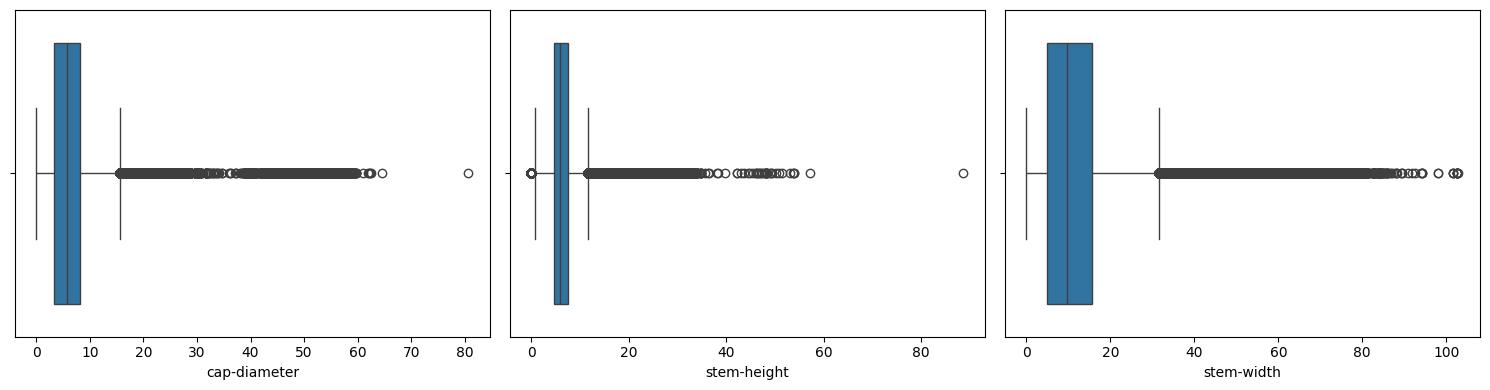

In [8]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
sns.boxplot(x=mushroom['cap-diameter'],ax=ax[0])
sns.boxplot(x=mushroom['stem-height'],ax=ax[1])
sns.boxplot(x=mushroom['stem-width'],ax=ax[2])
plt.tight_layout()
plt.show()

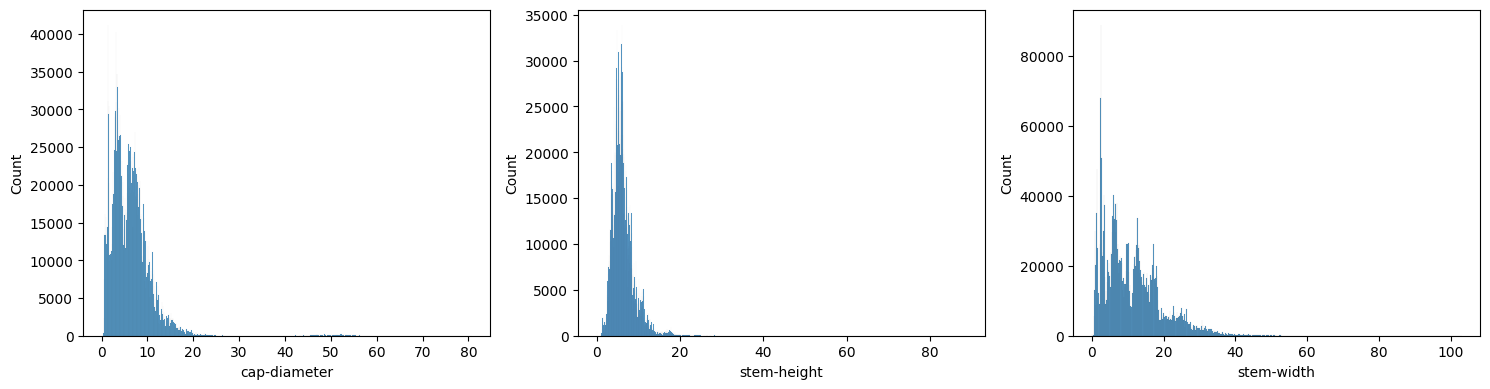

In [9]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
sns.histplot(mushroom['cap-diameter'],ax=ax[0])
sns.histplot(mushroom['stem-height'],ax=ax[1])
sns.histplot(mushroom['stem-width'],ax=ax[2])
plt.tight_layout()
plt.show()

- 'id' column does not serve any purpose, so dropping it

In [10]:
mushroom = mushroom.drop('id', axis=1)

In [11]:
null_columns_count = mushroom.isnull().sum()  # Get the count of nulls per column
columns_with_nulls = null_columns_count[null_columns_count > 0].index.tolist()
columns_with_nulls

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat']

- From the above we can notice that a number of columns have null records, let us find out the percentage of values missing in those columns. If the percentage of missing values is more than 40% then we drop the columns

In [12]:
null_columns_perc = 100*((mushroom.isnull().sum())/len(mushroom))
null_columns_perc

class                    0.000000
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-height              0.000000
stem-width               0.000000
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64

In [13]:
null_columns_perc_40 = null_columns_perc[null_columns_perc>40].index.tolist()
null_columns_perc_40

['gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

- The 5 columns - ['gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color'] - can be dropped as they have more than 40% missing values which means any analysis on those columns will not provide us with any useful information

In [14]:
null_columns_perc_below_40 = null_columns_perc[null_columns_perc<40].index.tolist()
null_columns_perc_below_40

['class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

- Found a very good medium article which suggests ways one can handle missing values -> https://medium.com/@pingsubhak/handling-missing-values-in-dataset-7-methods-that-you-need-to-know-5067d4e32b62

In [15]:
numerical_columns = mushroom.select_dtypes(exclude=['object', 'category']).columns.tolist()
numerical_columns

['class', 'cap-diameter', 'stem-height', 'stem-width']

In [16]:
# Define a transformer class to drop columns with more than 40% null values
class drop_cols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for dropping columns, return self
        return self
    
    def transform(self, X):
        # Drop columns with more than 40% null values
        X = X.drop(null_columns_perc_40, axis=1)
        return X

# Define a transformer class to clean the data by filling missing values
class data_cleaning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for filling missing values, return self
        return self
    
    def transform(self, X):
        # Iterate over all columns in the dataset
        for f in X.columns:
            # If the column is numeric (float64), fill NaN values with the median
            if X[f].dtype == 'float64':
                X[f] = X[f].fillna(value=X[f].median())
            else:
                # If the column is non-numeric, fill NaN values with the mode (most frequent value)
                X[f] = X[f].fillna(value=X[f].mode()[0])
        return X

# Define a transformer class to remove outliers from specified numerical columns
class Outlier_rem(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for outlier removal, return self
        return self
    
    def transform(self, X):
        # List of numerical columns to apply outlier removal
        numcol = ['cap-diameter', 'stem-height', 'stem-width']
        
        # Iterate over each numerical column
        for col in numcol:
            # Calculate the interquartile range (IQR)
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            
            # Define lower and upper bounds for outliers
            lwr = q1 - (1.5 * iqr)
            upr = q3 + (1.5 * iqr)
            
            # Apply the lower bound: Replace values below the lower bound with the lower bound
            X[col] = X[col].apply(lambda x: lwr if x < lwr else x)
            
            # Apply the upper bound: Replace values above the upper bound with the upper bound
            X[col] = X[col].apply(lambda x: upr if x > upr else x)
        
        return X

# Define a transformer class to encode categorical features using LabelEncoder
class encoding(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for label encoding, return self
        return self
    
    def transform(self, X):
        le = LabelEncoder()
        # Iterate over the columns that need encoding (those with <40% nulls)
        for col in null_columns_perc_below_40:
            # Apply label encoding to the column
            X[col] = le.fit_transform(X[col])
        return X

# Define a transformer class to scale numerical features using StandardScaler
class Scaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting necessary for scaling, return self
        return self
    
    def transform(self, X):
        sc = StandardScaler()
        # Check if the dataset contains the target column 'class'
        if 'class' in X.columns:
            # Scale all columns except 'class'
            for col in X.columns[1:]:
                X[col] = sc.fit_transform(X[[col]])
        else:
            # Scale all columns in the dataset
            for col in X.columns:
                X[col] = sc.fit_transform(X[[col]])
        return X

In [17]:
# Create a pipeline that chains together several preprocessing steps
pipeline = Pipeline([
    ('drop', drop_cols()),           # Step 1: Drop columns with more than 40% null values
    ('data_cleanup', data_cleaning()),  # Step 2: Clean data by filling missing values with median/mode
    ('Outlier', Outlier_rem()),         # Step 3: Remove outliers by capping them at 1.5 times the IQR
    ('encoding', encoding()),           # Step 4: Encode categorical features using LabelEncoder
    ('scaling', Scaling())              # Step 5: Scale numerical features using StandardScaler
])

# Apply the entire pipeline to the 'mushroom' dataset
# The pipeline sequentially applies each transformation to the data
mushroom = pipeline.fit_transform(mushroom)

# Now, 'mushroom' contains the preprocessed data with the steps applied in the specified order


<Axes: >

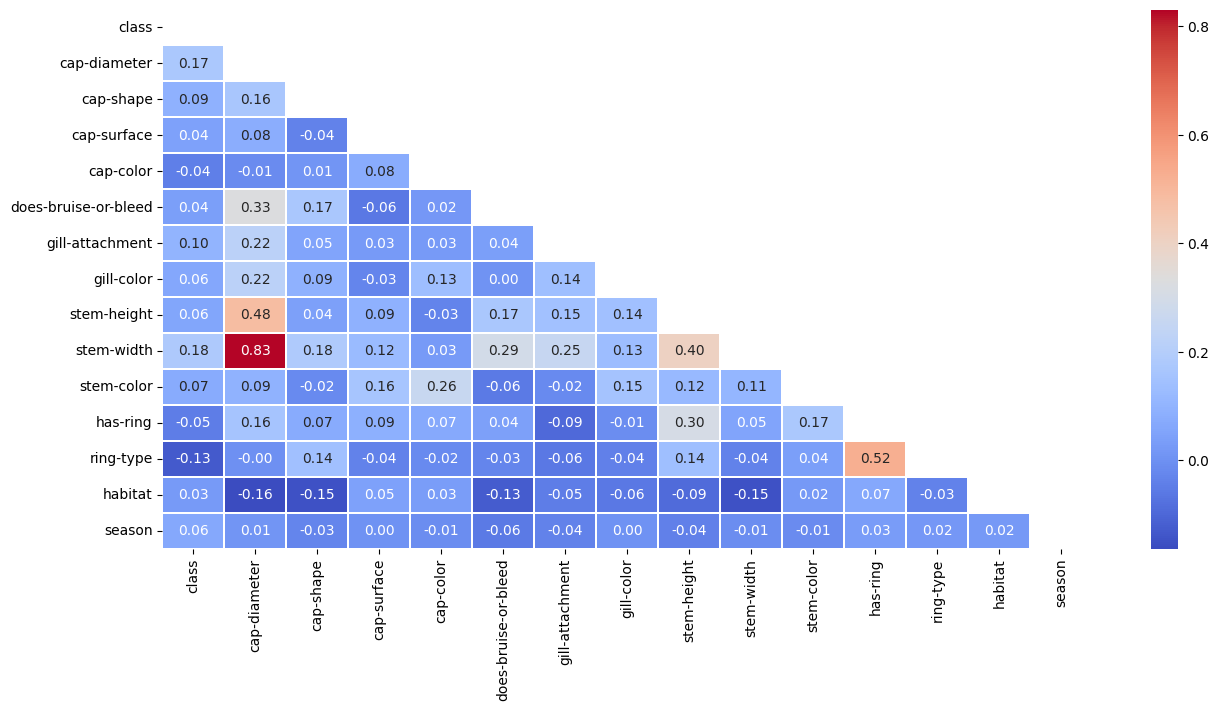

In [18]:
plt.figure(figsize=(15,7))
corr=mushroom.corr()
mask=np.triu(corr)
sns.heatmap(corr,mask=mask,linewidth=0.1,annot=True,cmap='coolwarm',fmt='.2f')

In [19]:
X = mushroom.drop('class', axis=1)
y = mushroom['class']

In [20]:
X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0.750900,-1.111069,0.329188,1.039733,-0.461411,-0.834809,0.895723,-0.760177,0.569844,0.785557,-0.561942,-0.294854,-0.535818,-0.954002
1,-0.449152,0.879158,-1.155119,-0.162778,-0.461411,-0.834809,-0.562029,-0.635374,-0.593913,-0.540141,1.779556,4.511319,-0.535818,1.762755
2,0.230597,-1.111069,0.329188,-2.417487,-0.461411,1.829251,0.895723,0.282816,-0.143300,-0.705853,-0.561942,-0.294854,2.118464,1.762755
3,-0.625384,-1.111069,1.164112,-1.214976,-0.461411,1.399564,-1.571242,-0.916180,-0.587382,0.785557,-0.561942,-0.294854,-0.535818,0.857169
4,-0.074311,0.879158,-0.320196,1.340360,-0.461411,-0.576997,0.895723,-1.268301,-0.348362,0.785557,-0.561942,-0.294854,0.429376,-0.954002


##### Check if the 'class' column is imbalanced

In [21]:
value_counts = y.value_counts()

# Print the value counts
print(value_counts)

class
0    1705396
1    1411549
Name: count, dtype: int64


In [22]:
X.isna().sum()

cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

### Train-test split and model training

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

##### Random Forest Classifier

In [24]:
# Initialize the Random Forest Classifier with specific hyperparameters
model_RF = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=30,            # Maximum depth of each tree
    min_samples_split=5,     # Minimum number of samples required to split an internal node
    random_state=42,         # Seed for random number generator for reproducibility
    n_jobs=-1                # Use all available cores for parallel computation
)

# Fit the model on the training data
# The model will learn from the training features (X_train) and their corresponding labels (y_train)
model_RF.fit(X_train, y_train)

# The model is now trained and can be used to make predictions on new data

RandomForestClassifier(max_depth=30, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [25]:
# Use the trained Random Forest model to make predictions on the test data
y_pred = model_RF.predict(X_test)

# Calculate and print the confusion matrix
# The confusion matrix provides a summary of the prediction results, showing the true positives, false positives, true negatives, and false negatives
print(confusion_matrix(y_test, y_pred))

# Calculate and print the Matthews correlation coefficient (MCC)
# MCC is a metric that provides a balanced measure of the quality of binary classifications, taking into account all four quadrants of the confusion matrix
# It returns a value between -1 and +1, where +1 indicates a perfect prediction, 0 indicates no better than random prediction, and -1 indicates total disagreement between prediction and observation
final_mcc_RF = matthews_corrcoef(y_test, y_pred)
print(final_mcc_RF)

[[505993   5626]
 [  4703 418762]]
0.977715884843926


In [26]:
final_accuracy_RF = accuracy_score(y_test, y_pred)
final_accuracy_RF

0.9889539335503549

#### XGBoost classifier using optuna

In [27]:
def objective(trial):
    # Suggest hyperparameters for optimization
    # 'n_estimators': Number of boosting rounds or trees in the ensemble
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    
    # 'max_depth': Maximum depth of each tree; deeper trees can capture more complexity but may overfit
    max_depth = trial.suggest_int('max_depth', 3, 10)
    
    # 'learning_rate': Step size shrinkage used to prevent overfitting; smaller values make the model more robust
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    
    # 'subsample': Fraction of the training data to be randomly sampled for each tree; helps prevent overfitting
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    # 'colsample_bytree': Fraction of features to be randomly sampled for each tree; helps reduce overfitting by introducing randomness
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    # Create the XGBoost model with the suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators,          # Number of boosting rounds
        max_depth=max_depth,                # Maximum depth of each tree
        learning_rate=learning_rate,        # Learning rate (step size)
        subsample=subsample,                # Subsample ratio of the training instances
        colsample_bytree=colsample_bytree,  # Subsample ratio of columns when constructing each tree
        use_label_encoder=False,            # Disable automatic label encoding
        eval_metric='logloss'               # Evaluation metric to optimize during training
    )

    # Split the dataset into training and test sets (80% training, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = model.predict(X_test)

    # Calculate the Matthews Correlation Coefficient (MCC) for the model on the test set
    mcc = matthews_corrcoef(y_test, y_pred)

    # Return the MCC as the metric to be maximized by Optuna
    return mcc  # Optuna will maximize this metric

In [28]:
# Create a study object
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

[I 2024-09-03 08:43:43,241] A new study created in memory with name: no-name-de6434c4-ea4d-43fe-9a3a-c8e3c719e298
[I 2024-09-03 08:43:47,165] Trial 0 finished with value: 0.9535821310661357 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.19573373292990506, 'subsample': 0.9094182012795451, 'colsample_bytree': 0.844707343494641}. Best is trial 0 with value: 0.9535821310661357.
[I 2024-09-03 08:43:58,220] Trial 1 finished with value: 0.9773501241225077 and parameters: {'n_estimators': 217, 'max_depth': 10, 'learning_rate': 0.0965012314758453, 'subsample': 0.9696567698172962, 'colsample_bytree': 0.6433797950179123}. Best is trial 1 with value: 0.9773501241225077.
[I 2024-09-03 08:44:07,862] Trial 2 finished with value: 0.966559946963729 and parameters: {'n_estimators': 256, 'max_depth': 7, 'learning_rate': 0.04312006620214474, 'subsample': 0.8220888399976022, 'colsample_bytree': 0.833775782991753}. Best is trial 1 with value: 0.9773501241225077.
[I 2024-09-03 08:44

In [29]:
print("Best hyperparameters found by Optuna:")
print(study.best_params)

Best hyperparameters found by Optuna:
{'n_estimators': 311, 'max_depth': 9, 'learning_rate': 0.15615049260510477, 'subsample': 0.7502681883341552, 'colsample_bytree': 0.9342057059254495}


In [30]:
best_trial = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial.value}")

print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.9775161430123406
  Best hyperparameters:
    n_estimators: 311
    max_depth: 9
    learning_rate: 0.15615049260510477
    subsample: 0.7502681883341552
    colsample_bytree: 0.9342057059254495


In [31]:
# Initialize the XGBoost model using the best hyperparameters found by Optuna
model_XGB = XGBClassifier(
    **study.best_params,       # Unpack and use the best hyperparameters found by Optuna
    use_label_encoder=False,   # Disable automatic label encoding (useful if labels are already encoded)
    eval_metric='logloss',     # Use log loss as the evaluation metric during training
    random_state=42            # Set a random seed for reproducibility
)

# Train the XGBoost model on the training data
model_XGB.fit(X_train, y_train)

# The model is now trained with the optimal hyperparameters and ready to be evaluated or used for predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9342057059254495, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15615049260510477,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=311, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [32]:
y_pred = model_XGB.predict(X_test)

In [33]:
print(confusion_matrix(y_test,y_pred))
final_mcc_XG = matthews_corrcoef(y_test,y_pred)
print(final_mcc_XG)

[[505885   5734]
 [  4701 418764]]
0.9774881698927682


In [34]:
final_accuracy_XG = accuracy_score(y_test, y_pred)
final_accuracy_XG

0.9888405747505037

#### LightBGM using optuna

In [35]:
from sklearn.metrics import matthews_corrcoef

def objective(trial):
    # Define hyperparameters to optimize using Optuna
    param = {
        'objective': 'binary',  # Specify binary classification; use 'regression' for regression tasks
        'metric': 'binary_logloss',  # Use log loss for binary classification; use 'rmse' for regression tasks
        'boosting_type': 'gbdt',  # Specify the boosting type; 'gbdt' is the traditional Gradient Boosting Decision Trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Learning rate controls how much to adjust the weights with respect to the loss gradient
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Number of leaves in one tree; higher values can capture more complexity
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Maximum depth of each tree to control model complexity and prevent overfitting
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),  # Minimum number of data points required in a leaf node to prevent overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),  # Fraction of features to consider for each boosting round to prevent overfitting
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),  # Fraction of data to be used for each boosting round (random sampling with replacement)
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  # Frequency of bagging, controls how often bagging is used (e.g., every k iterations)
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),  # L1 regularization term on weights (Lasso)
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),  # L2 regularization term on weights (Ridge)
    }

    # Create the LightGBM dataset using the training data
    dtrain = lgb.Dataset(X_train, label=y_train)

    # Train the LightGBM model with the current set of hyperparameters
    gbm = lgb.train(param, dtrain)

    # Predict probabilities on the test set
    y_pred = gbm.predict(X_test)
    
    # Convert probabilities to binary class labels (0 or 1) based on a threshold of 0.5
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

    # Calculate the Matthews Correlation Coefficient (MCC) on the test set
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Return the MCC as the metric to be maximized by Optuna
    return mcc  # Optuna will maximize this metric during hyperparameter optimization

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

[I 2024-09-03 08:56:47,498] A new study created in memory with name: no-name-fe6fd874-00c0-4c3a-96a1-c79447fdd6c0


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110


[I 2024-09-03 08:56:55,704] Trial 0 finished with value: 0.9491115167468362 and parameters: {'learning_rate': 0.026727621718812166, 'num_leaves': 74, 'max_depth': 14, 'min_data_in_leaf': 60, 'feature_fraction': 0.9678903890183047, 'bagging_fraction': 0.690920268337926, 'bagging_freq': 3, 'lambda_l1': 5.772967988058344, 'lambda_l2': 8.50998834525997}. Best is trial 0 with value: 0.9491115167468362.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-09-03 08:56:59,633] Trial 1 finished with value: 0.9410336030149059 and parameters: {'learning_rate': 0.12200446299511898, 'num_leaves': 30, 'max_depth': 5, 'min_data_in_leaf': 23, 'feature_fraction': 0.6562404756399535, 'bagging_fraction': 0.7120390765108251, 'bagging_freq': 10, 'lambda_l1': 0.23780417457299974, 'lambda_l2': 3.1254001209967788}. Best is trial 0 with value: 0.9491115167468362.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110


[I 2024-09-03 08:57:09,202] Trial 2 finished with value: 0.971886233298683 and parameters: {'learning_rate': 0.06178555989600233, 'num_leaves': 148, 'max_depth': 13, 'min_data_in_leaf': 45, 'feature_fraction': 0.7627771876418786, 'bagging_fraction': 0.727118891267077, 'bagging_freq': 9, 'lambda_l1': 9.05222398785936, 'lambda_l2': 9.242469176876039}. Best is trial 2 with value: 0.971886233298683.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-09-03 08:57:12,019] Trial 3 finished with value: 0.9062140107280056 and parameters: {'learning_rate': 0.24586431513060647, 'num_leaves': 57, 'max_depth': 3, 'min_data_in_leaf': 88, 'feature_fraction': 0.7228479436152803, 'bagging_fraction': 0.7839932731679636, 'bagging_freq': 2, 'lambda_l1': 7.700150927108286, 'lambda_l2': 3.36646876775529}. Best is trial 2 with value: 0.971886233298683.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-09-03 08:57:18,577] Trial 4 finished with value: 0.9666128706491437 and parameters: {'learning_rate': 0.08899643627642399, 'num_leaves': 62, 'max_depth': 8, 'min_data_in_leaf': 87, 'feature_fraction': 0.662646236339019, 'bagging_fraction': 0.7279335179602718, 'bagging_freq': 3, 'lambda_l1': 9.028032759623795, 'lambda_l2': 2.713517191966879}. Best is trial 2 with value: 0.971886233298683.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-09-03 08:57:23,084] Trial 5 finished with value: 0.9666284244610345 and parameters: {'learning_rate': 0.29493558983200596, 'num_leaves': 37, 'max_depth': 5, 'min_data_in_leaf': 44, 'feature_fraction': 0.629773389851632, 'bagging_fraction': 0.8603889396674345, 'bagging_freq': 2, 'lambda_l1': 2.59485039508234, 'lambda_l2': 8.587159391224935}. Best is trial 2 with value: 0.971886233298683.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-09-03 08:57:26,794] Trial 6 finished with value: 0.8552812089286043 and parameters: {'learning_rate': 0.06396400933889204, 'num_leaves': 22, 'max_depth': 4, 'min_data_in_leaf': 84, 'feature_fraction': 0.9491237399312694, 'bagging_fraction': 0.9350194204485192, 'bagging_freq': 3, 'lambda_l1': 0.7381359032950185, 'lambda_l2': 5.638143811035816}. Best is trial 2 with value: 0.971886233298683.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110


[I 2024-09-03 08:57:36,183] Trial 7 finished with value: 0.9484934369729286 and parameters: {'learning_rate': 0.02306376156692255, 'num_leaves': 110, 'max_depth': 11, 'min_data_in_leaf': 72, 'feature_fraction': 0.9868244908625448, 'bagging_fraction': 0.9928081909457827, 'bagging_freq': 6, 'lambda_l1': 8.727136322050612, 'lambda_l2': 3.3159223628075942}. Best is trial 2 with value: 0.971886233298683.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110


[I 2024-09-03 08:57:44,359] Trial 8 finished with value: 0.9729753996338153 and parameters: {'learning_rate': 0.10423583753887519, 'num_leaves': 84, 'max_depth': 11, 'min_data_in_leaf': 32, 'feature_fraction': 0.6914998285462145, 'bagging_fraction': 0.7043859501733757, 'bagging_freq': 2, 'lambda_l1': 1.559537840584263, 'lambda_l2': 9.862210820497797}. Best is trial 8 with value: 0.9729753996338153.


[LightGBM] [Info] Number of positive: 988084, number of negative: 1193777
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452863 -> initscore=-0.189110
[LightGBM] [Info] Start training from score -0.189110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-09-03 08:57:46,450] Trial 9 finished with value: 0.8819062511278982 and parameters: {'learning_rate': 0.20451410764348596, 'num_leaves': 79, 'max_depth': 3, 'min_data_in_leaf': 72, 'feature_fraction': 0.9031935456142213, 'bagging_fraction': 0.6492520807453935, 'bagging_freq': 1, 'lambda_l1': 6.633084902692944, 'lambda_l2': 1.7751755780551703}. Best is trial 8 with value: 0.9729753996338153.


In [37]:
print("Best hyperparameters found by Optuna:")
print(study.best_params)

print("Best trial:")
print(f"  Value: {study.best_trial.value}")

Best hyperparameters found by Optuna:
{'learning_rate': 0.10423583753887519, 'num_leaves': 84, 'max_depth': 11, 'min_data_in_leaf': 32, 'feature_fraction': 0.6914998285462145, 'bagging_fraction': 0.7043859501733757, 'bagging_freq': 2, 'lambda_l1': 1.559537840584263, 'lambda_l2': 9.862210820497797}
Best trial:
  Value: 0.9729753996338153


In [38]:
# Get the best parameters from the Optuna study
best_params = study.best_params

# Train the final LightGBM model with the best parameters
dtrain = lgb.Dataset(X_train, label=y_train)
model_LGB = lgb.train(best_params, dtrain)

# Predict on the test set
y_pred = model_LGB.predict(X_test)

# Convert probabilities to binary class labels (0 or 1) based on a threshold of 0.5
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the final model using accuracy
final_accuracy_LGB = accuracy_score(y_test, y_pred)
print(f'Final Model Accuracy: {final_accuracy_LGB}')

# Evaluate the final model using Matthews Correlation Coefficient (MCC)
final_mcc_LGB = matthews_corrcoef(y_test, y_pred)
print(f'Final Model MCC: {final_mcc_LGB}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 2181861, number of used features: 14
[LightGBM] [Info] Start training from score 0.452863
Final Model Accuracy: 0.9845960362919267
Final Model MCC: 0.9689268086954556


### Comparing the three models

In [39]:
data = {
    'Model': ['Random Forest Classifier', 'XGBoost', 'LightGBM'],
    'Accuracy': [final_accuracy_RF, final_accuracy_XG, final_accuracy_LGB],
    'MCC': [final_mcc_RF, final_mcc_XG, final_mcc_LGB],  # Add the MCC values here
    'Best Model (Accuracy)': ['Yes' if acc == max(final_accuracy_RF, final_accuracy_XG, final_accuracy_LGB) else 'No' for acc in [final_accuracy_RF, final_accuracy_XG, final_accuracy_LGB]],
    'Best Model (MCC)': ['Yes' if mcc == max(final_mcc_RF, final_mcc_XG, final_mcc_LGB) else 'No' for mcc in [final_mcc_RF, final_mcc_XG, final_mcc_LGB]]  # Identify the best model based on MCC
}

df = pd.DataFrame(data)
print(df)

                      Model  Accuracy       MCC Best Model (Accuracy) Best Model (MCC)
0  Random Forest Classifier  0.988954  0.977716                   Yes              Yes
1                   XGBoost  0.988841  0.977488                    No               No
2                  LightGBM  0.984596  0.968927                    No               No


### Testing the model on the test dataset

In [40]:
mushroom_test = pd.read_csv('test.csv')
mushroom_test.head(3)

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s


In [41]:
ids=mushroom_test['id']
mushroom_test=mushroom_test.drop('id',axis=1)

In [42]:
null_columns_perc_below_40.remove('class')
null_columns_perc_below_40

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [43]:
pipeline_t=Pipeline([
    ('drop',drop_cols()),
    ('data_cleanup',data_cleaning()),
    ('encoding',encoding()),
    ('scaling',Scaling())
])
mushroom_test=pipeline_t.fit_transform(mushroom_test)

In [44]:
# Use the trained XGBoost model to make predictions on the mushroom_test dataset
y_submission_RF = model_RF.predict(mushroom_test)

# Convert the predicted probabilities to binary class labels (0 or 1)
# If a predicted probability is greater than 0.5, it is classified as 1 (positive class)
# Otherwise, it is classified as 0 (negative class)
y_submission_RF = (y_submission_RF > 0.5).astype(int)

# The resulting y_submission array now contains the final binary predictions (0 or 1) for each instance in mushroom_test

In [45]:
# Convert the binary predictions back to their original categorical labels
# 'p' represents the poisonous class (pred == 0)
# 'e' represents the edible class (pred == 1)
# For each prediction in y_submission, if the prediction is 0, it is labeled as 'p'
# Otherwise, it is labeled as 'e'
y_submission_RF = ['p' if pred == 0 else 'e' for pred in y_submission_RF]

# The resulting y_submission list now contains the original class labels ('p' for poisonous, 'e' for edible)

In [46]:
y_submission_RF[:10]

['e', 'p', 'p', 'p', 'e', 'e', 'e', 'p', 'p', 'e']

### Csv file with final results

In [47]:
predict_RF =pd.DataFrame({'id':ids,'class':y_submission_RF})

In [48]:
predict_RF.head(10)

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
5,3116950,e
6,3116951,e
7,3116952,p
8,3116953,p
9,3116954,e


In [49]:
predict_RF.to_csv('submission_RF.csv',index=False)

### Testing the other two models as well

In [50]:
# Use the trained XGBoost model to make predictions on the mushroom_test dataset
y_submission_XGB = model_XGB.predict(mushroom_test)

# Convert the predicted probabilities to binary class labels (0 or 1)
# If a predicted probability is greater than 0.5, it is classified as 1 (positive class)
# Otherwise, it is classified as 0 (negative class)
y_submission_XGB = (y_submission_XGB > 0.5).astype(int)

# The resulting y_submission array now contains the final binary predictions (0 or 1) for each instance in mushroom_test

In [51]:
# Convert the binary predictions back to their original categorical labels
# 'p' represents the poisonous class (pred == 0)
# 'e' represents the edible class (pred == 1)
# For each prediction in y_submission, if the prediction is 0, it is labeled as 'p'
# Otherwise, it is labeled as 'e'
y_submission_XGB = ['p' if pred == 0 else 'e' for pred in y_submission_XGB]

# The resulting y_submission list now contains the original class labels ('p' for poisonous, 'e' for edible)

In [52]:
predict_XGB=pd.DataFrame({'id':ids,'class':y_submission_XGB})

In [53]:
predict_XGB.to_csv('submission_XGB.csv',index=False)

In [54]:
# Use the trained XGBoost model to make predictions on the mushroom_test dataset
y_submission_LGB = model_LGB.predict(mushroom_test)

# Convert the predicted probabilities to binary class labels (0 or 1)
# If a predicted probability is greater than 0.5, it is classified as 1 (positive class)
# Otherwise, it is classified as 0 (negative class)
y_submission_LGB = (y_submission_LGB > 0.5).astype(int)

# The resulting y_submission array now contains the final binary predictions (0 or 1) for each instance in mushroom_test

In [55]:
# Convert the binary predictions back to their original categorical labels
# 'p' represents the poisonous class (pred == 0)
# 'e' represents the edible class (pred == 1)
# For each prediction in y_submission, if the prediction is 0, it is labeled as 'p'
# Otherwise, it is labeled as 'e'
y_submission_LGB = ['p' if pred == 0 else 'e' for pred in y_submission_LGB]

# The resulting y_submission list now contains the original class labels ('p' for poisonous, 'e' for edible)

In [56]:
predict_LGB=pd.DataFrame({'id':ids,'class':y_submission_LGB})

In [57]:
predict_LGB.to_csv('submission_LGB.csv',index=False)